In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import find_peaks
from scipy import integrate

In [18]:
def bartlet_function(t):
    result = np.zeros_like(t)
    
    mask = (t >= 0) & (t <= 1)
    
    result[mask] = (1 - abs(1 - 2 * t[mask]))
    
    return result

In [ ]:
N = 4096
t = np.linspace(-0.5, 1.5, N)
dt = t[1] - t[0]


bartlet_signal = bartlet_function(t)

/tmp/ipykernel_89590/133452030.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


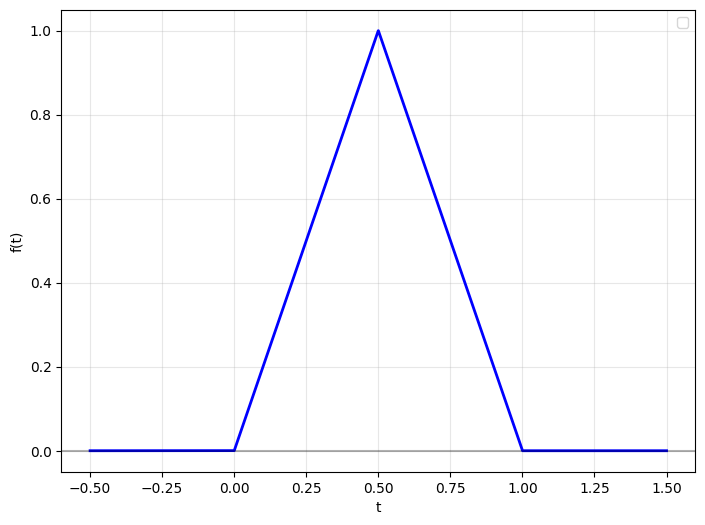

In [20]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(t, bartlet_signal, 'b-', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('t')
plt.ylabel('f(t)')
plt.grid(True, alpha=0.3)
plt.legend()

In [22]:
freq = fftshift(fftfreq(N, dt))
spectrum = fftshift(fft(bartlet_signal))

amplitude_spectrum = np.abs(spectrum)

amplitude_spectrum_norm = amplitude_spectrum / np.max(amplitude_spectrum)
log_amplitude_norm = 20 * np.log10(amplitude_spectrum_norm + 1e-12)

power_spectrum = amplitude_spectrum_norm**2

main_lobe_mask = (freq >= -5) & (freq <= 5)
main_lobe_freq = freq[main_lobe_mask]
main_lobe_power = power_spectrum[main_lobe_mask]

main_peak_idx = np.argmax(main_lobe_power)
main_peak_freq = main_lobe_freq[main_peak_idx]
main_peak_power = main_lobe_power[main_peak_idx]

half_power_level = 0.5
half_power_dB = 10 * np.log10(0.5)

In [24]:
crossings = []
for i in range(len(main_lobe_power) - 1):
    if (main_lobe_power[i] - half_power_level) * (main_lobe_power[i+1] - half_power_level) <= 0:
        x1, x2 = main_lobe_freq[i], main_lobe_freq[i+1]
        y1, y2 = main_lobe_power[i], main_lobe_power[i+1]
        x_cross = x1 + (x2 - x1) * (half_power_level - y1) / (y2 - y1)
        crossings.append(x_cross)

if len(crossings) >= 2:
    fwhm_power = abs(crossings[1] - crossings[0])
else:
    half_power_indices = np.where(main_lobe_power >= half_power_level)[0]
    fwhm_power = abs(main_lobe_freq[half_power_indices[-1]] - main_lobe_freq[half_power_indices[0]])

half_amplitude_level = 1/np.sqrt(2)
crossings_amplitude = []

for i in range(len(amplitude_spectrum_norm) - 1):
    if (amplitude_spectrum_norm[i] - half_amplitude_level) * (amplitude_spectrum_norm[i+1] - half_amplitude_level) <= 0:
        if abs(freq[i]) < 3: 
            x1, x2 = freq[i], freq[i+1]
            y1, y2 = amplitude_spectrum_norm[i], amplitude_spectrum_norm[i+1]
            x_cross = x1 + (x2 - x1) * (half_amplitude_level - y1) / (y2 - y1)
            crossings_amplitude.append(x_cross)

if len(crossings_amplitude) >= 2:
    fwhm_amplitude = abs(crossings_amplitude[1] - crossings_amplitude[0])

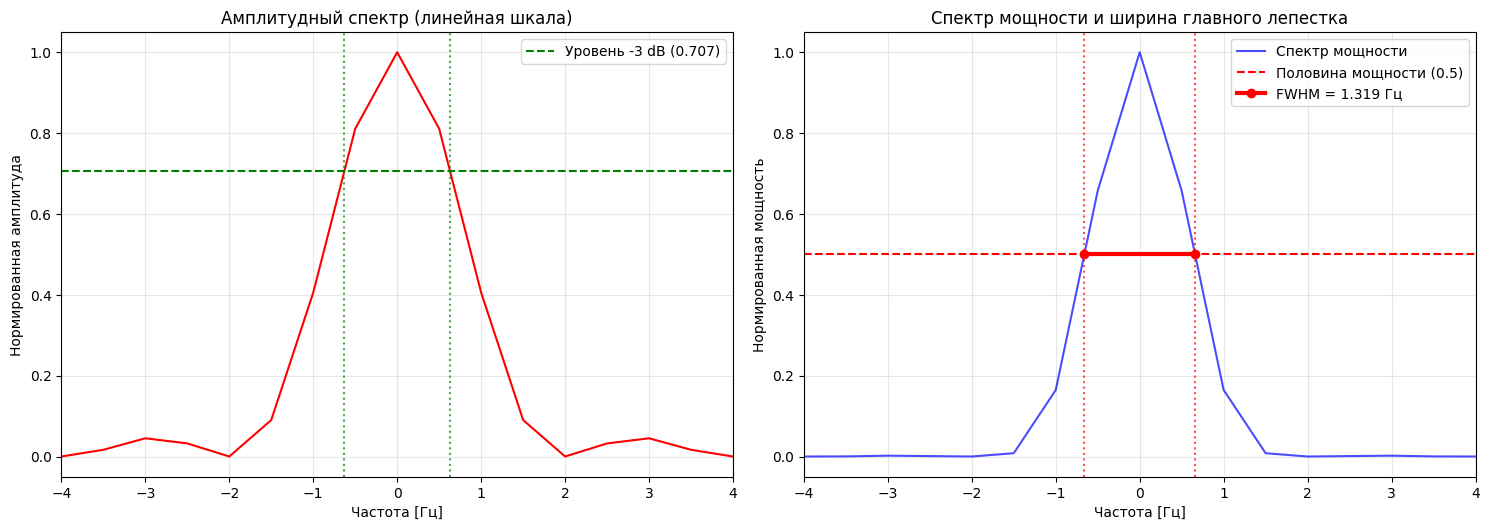

In [27]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(freq, amplitude_spectrum_norm, 'r-', linewidth=1.5)
plt.axhline(y=half_amplitude_level, color='g', linestyle='--', 
           label=f'Уровень -3 dB ({half_amplitude_level:.3f})')

if len(crossings_amplitude) >= 2:
    plt.axvline(x=crossings_amplitude[0], color='g', linestyle=':', alpha=0.7)
    plt.axvline(x=crossings_amplitude[1], color='g', linestyle=':', alpha=0.7)

plt.xlabel('Частота [Гц]')
plt.ylabel('Нормированная амплитуда')
plt.title('Амплитудный спектр (линейная шкала)')
plt.grid(True, alpha=0.3)
plt.xlim(-4, 4)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(freq, power_spectrum, 'b-', linewidth=1.5, alpha=0.7, label='Спектр мощности')
plt.axhline(y=half_power_level, color='red', linestyle='--', 
           label=f'Половина мощности ({half_power_level})')
if len(crossings) >= 2:
    plt.axvline(x=crossings[0], color='red', linestyle=':', alpha=0.7)
    plt.axvline(x=crossings[1], color='red', linestyle=':', alpha=0.7)
    plt.plot([crossings[0], crossings[1]], [half_power_level, half_power_level], 
             'ro-', linewidth=3, label=f'FWHM = {fwhm_power:.3f} Гц')
plt.xlabel('Частота [Гц]')
plt.ylabel('Нормированная мощность')
plt.title('Спектр мощности и ширина главного лепестка')
plt.grid(True, alpha=0.3)
plt.xlim(-4, 4)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def bartlet_window(t):
    return 0.42659 - 0.49656 * np.cos(2 * np.pi * t) + 0.076849 * np.cos(4 * np.pi * t)

# 1. Аналитический расчет коэффициента ослабления
def analytical_coherent_gain():
    """Аналитический расчет коэффициента ослабления через интегрирование"""
    # Интегрируем функцию Блекмана на интервале [0,1]
    result, error = integrate.quad(bartlet_window, 0, 1)
    return result